The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


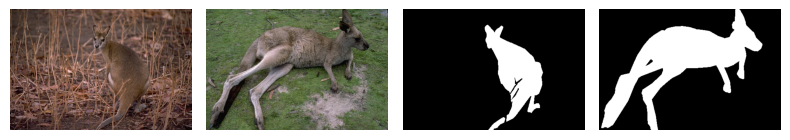

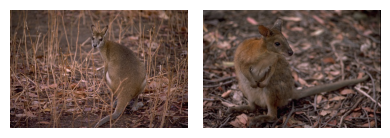

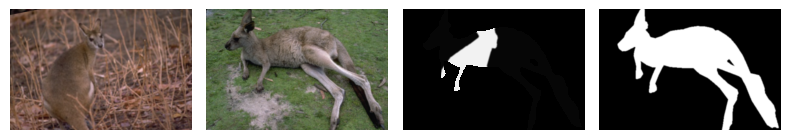

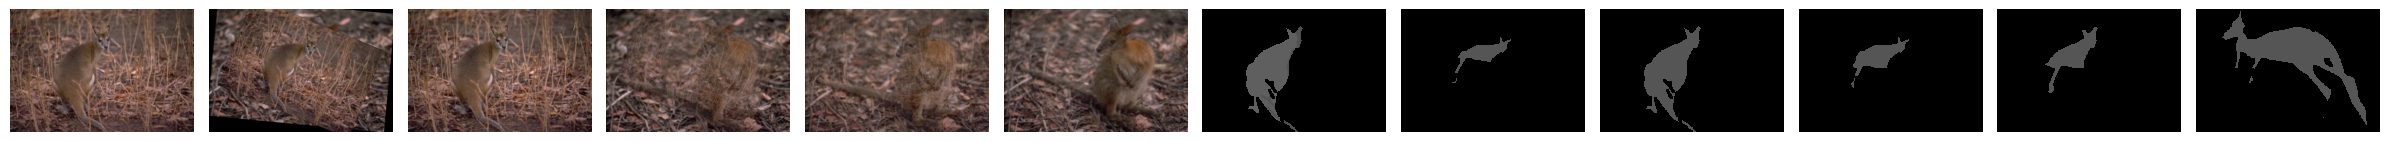

In [57]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import sys
import torch
import torch.utils.data as data
import torch.nn as nn
import easydict
import kornia as K
import torch.nn.functional as F


sys.path.append("..")
import mixmatch
import datasets
import transformations as custom_transforms
import utils
import losses
import models
import ramps 


# Create SegmentationDatasetLabeled
labeled_dataset = datasets.SegmentationDatasetLabeled(
    dir_images="./my_dataset/images/",
    dir_masks="./my_dataset/masks/",
    #transform=transforms.ToTensor()
)

# Create DataLoader for SegmentationDatasetLabeled
batch_size = 2  # set your desired batch size
labeled_dataloader = data.DataLoader(
    labeled_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1  # set the number of worker processes for loading data
)

# Create SegmentationDatasetUnlabeled
unlabeled_dataset = datasets.SegmentationDatasetUnlabeled(
    dir_images="./my_dataset/images/",
    #transform=transforms.ToTensor()
)

# Create DataLoader for SegmentationDatasetUnlabeled
unlabeled_dataloader = data.DataLoader(
    unlabeled_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1  # set the number of worker processes for loading data
)

import torch

args = easydict.EasyDict()
# CIFAR 10 reference setting 
args.train_iteration = 1
args.K = 2
args.T = 0.5
args.alpha = 0.75
args.lam_u = 75 
args.rampup_length = 16000
args.lr = 0.001 
args.device = 'cpu'

# Transforamtion
k1 = custom_transforms.GaussianNoiseChannelwise((0.01, 0.02, 0.025))
k2 = K.augmentation.RandomGaussianBlur((3,3),sigma=(1.,1.),p = 1)
k3 = K.augmentation.RandomHorizontalFlip(p=1)
k4 = K.augmentation.RandomAffine([-45., 45.], [0., 0.15], [0.5, 1.5], [0., 0.15])

img_trans = nn.ModuleList([k1,k2,k3,k4])
mask_trans = nn.ModuleList([k2,k3,k4]) 
invert_trans  = nn.ModuleList([k3,k4])

transform = custom_transforms.MyAugmentation(img_trans,mask_trans,invert_trans)

model = None # TODO: load model
opt = torch.optim.Adam(params=model.params,lr = args.lr)

labeled_train_iter = iter(labeled_dataloader)
unlabeled_train_iter = iter(unlabeled_dataloader)

# Iterate over index iterator until the desired number of iteration is achived


# Preparation for training function 

# Use Teacher if desired
if args.use_ema:
    mixmatch_clf = models.Mean_Teacher(model)
else:
    mixmatch_clf = model

model.train()
model.to(args.device)
for batch_idx in range(args.train_iteration):
    
    # Iterate over the end if necessary (Can be used with different sizes of dataloaders)
    try:
        data_l, labels = next(labeled_train_iter)
    except:
        labeled_train_iter = iter(labeled_dataloader)
        data_l, labels = next(labeled_train_iter)

    try:
        data_u = next(unlabeled_train_iter)
    except:
        unlabeled_train_iter = iter(unlabeled_dataloader)
        data_u = next(unlabeled_train_iter)

    data_l = data_l.to(args.device)
    labels = labels.to(args.device)
    data_u = data_u.to(args.device)

    with torch.no_grad():
        l_batch,u_batch = mixmatch.mixmatch(labeled_batch=data_l,
                                                labels=labels,
                                                unlabeled_batch=data_u,
                                                clf=mixmatch_clf,
                                                augumentation=transform,
                                                K=args.K,
                                                T=args.T,
                                                alpha=args.alpha)
        lx,ly = l_batch[0],l_batch[1]
        ux,uy = u_batch[0],u_batch[1]
        
    
    loss_supervised = torch.sum(losses.soft_cross_entropy(model(lx),ly,reduction='mean'))
    loss_unsepervised = torch.sum(losses.mse_softmax(model(ux),uy,reduction='mean')) 
    lam_u = ramps.linear_rampup(current = batch_idx, args.rampup_length) * args.lam_u
    loss = loss_supervised + lam_u * loss_unsepervised
    
    # SGD
    opt.zero_grad()
    loss.backward()
    opt.step()
    if args.use_ema: 
        mixmatch_clf.update_weights(model)
    

    # Save metrics 


    # Save model if log